In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pennylane import numpy as pnp
from tqdm import tqdm
import pennylane as qml
import tensorflow as tf
from tensorflow import keras

2024-01-06 18:41:27.855364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 18:41:27.855413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 18:41:27.855999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 18:41:27.859491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 18:41:28.434964: W tensorflow/compiler/tf2

In [2]:
pnp.random.seed(42)
np.random_seed = 42

In [3]:
def generate_dataset(n_sample):
    
    X = 2 * np.random.random((n_sample, 2)) -1
    y = np.sum(X, axis=1) >= 0
    
    y = y.astype("int32")
    y = y * 2 - 1
    
    return X, y

In [4]:
def show(X, y):
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolor='k', label='Class 1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='b', marker='o', edgecolor='k', label='Class 0')
    
    plt.title("Data for Quantum Classication")
    plt.xlabel("Feature 1")
    plt.xlabel("Feature 2")
    
    plt.legend()
    plt.show()

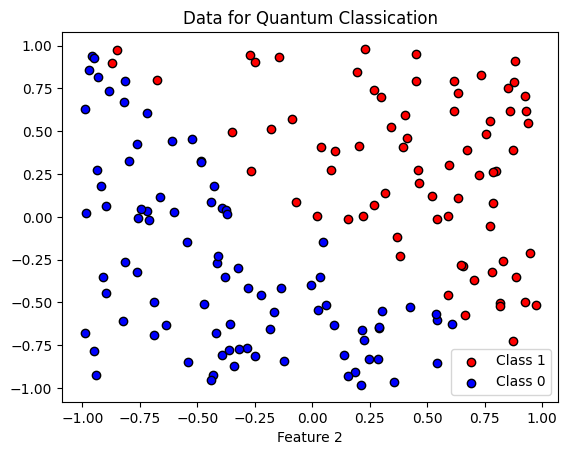

In [5]:
num_samples = 160

X, y = generate_dataset(num_samples)

show(X, y)

In [6]:
device = qml.device("default.qubit", wires=2)

In [7]:
def quantum_circuit(weights):
    qml.CNOT(wires=[1, 0])
    
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2], wires=0)
    #qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2], wires=1)

    qml.CNOT(wires=[0, 1])
    

In [8]:
@qml.qnode(device, diff_method="parameter-shift", max_diff=8)
def layer(weights, x):
    qml.AngleEmbedding(x, wires=[0, 1])
    
    for weight in weights:
        quantum_circuit(weight)
    
    return qml.expval(qml.PauliZ(0)) # eval the output 

In [9]:
def mean_squared_error(actual_values, predicted_values):
    n_samples = len(actual_values)
    squared_error = [(actual - predicted) ** 2 for actual, predicted in zip(actual_values, predicted_values)]
    mse = sum(squared_error) / n_samples
    return mse

In [10]:
def classifier(weight, bias, x):
    return layer(weight, x) + bias

In [11]:
def accuracy(labels, predictions):

    metric = 0
    for label, prediction in zip(labels, predictions):
        if abs(label - prediction) < 1e-5:
            metric += 1
            
    metric = metric / len(labels)
    
    return metric

In [12]:
def loss_fn(weights, bias, X, Y):
    
    prediction = [classifier(weights, bias, x) for x in X]
    
    loss = mean_squared_error(Y, prediction)    
    return loss

In [13]:
X = pnp.array(X[:], requires_grad=False)
Y = pnp.array(y[:], requires_grad=False)

In [14]:
num_qubits = 2
num_layers = 1
weights_init = 0.01 * pnp.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = pnp.array(0.0, requires_grad=True)
print(weights_init, bias_init)

[[[ 0.00945382  0.01266407  0.00377296]
  [ 0.01651351 -0.01326832  0.01843716]]] 0.0


/tmp/ipykernel_2118/562676348.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


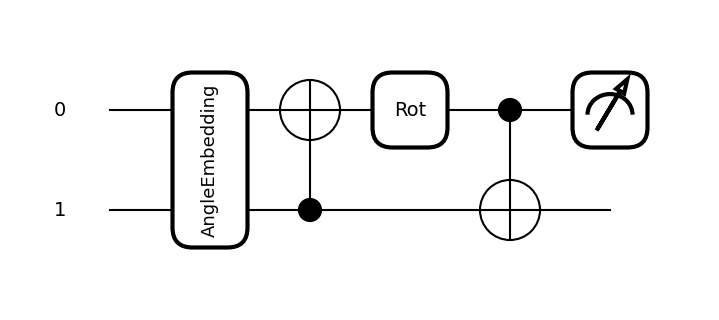

In [15]:
fig, ax = qml.draw_mpl(layer)(weights_init, X[0])
fig.show()

In [16]:
# defined hyperparameters for training
learning_rate = 0.02
batch_size = 4

In [17]:
weights = weights_init
bias = bias_init
for epoch in range(20):
    print(f"Starting epoch: {epoch + 1}")
    # Update the weights by one optimizer step
    
    bacth_index = np.random.randint(0, len(X), (batch_size, ))
    X_batch = X[bacth_index]
    y_batch = y[bacth_index]
    
    grad_fn = qml.grad(loss_fn)
    
    weights_grad, bias_grad = grad_fn(weights, bias, X_batch, y_batch)
    
    bias = bias - bias_grad * learning_rate
    weights = weights - weights_grad * learning_rate
    
    prediction = [np.sign(classifier(weights, bias, x)) for x in X]
    acc = accuracy(y, prediction)
    
    print(f"Loss: {loss_fn(weights, bias, X_batch, y_batch)} Accuracy {acc}")
    
    

Starting epoch: 1
Loss: 1.520880324026247 Accuracy 0.45625
Starting epoch: 2
Loss: 0.6019962491689623 Accuracy 0.45625
Starting epoch: 3
Loss: 1.2003617617999456 Accuracy 0.45625
Starting epoch: 4
Loss: 2.8553110182568737 Accuracy 0.45625
Starting epoch: 5
Loss: 0.6350894985777225 Accuracy 0.45625
Starting epoch: 6
Loss: 0.5688098398681571 Accuracy 0.45625
Starting epoch: 7
Loss: 2.3650470480779933 Accuracy 0.45625
Starting epoch: 8
Loss: 1.69979141751686 Accuracy 0.45625
Starting epoch: 9
Loss: 0.871734111353835 Accuracy 0.45625
Starting epoch: 10
Loss: 1.9216726394907357 Accuracy 0.45625
Starting epoch: 11
Loss: 1.0572568680358545 Accuracy 0.45625
Starting epoch: 12
Loss: 1.6719247552650478 Accuracy 0.475
Starting epoch: 13
Loss: 0.9226962023083551 Accuracy 0.475
Starting epoch: 14
Loss: 1.7212844055521361 Accuracy 0.46875
Starting epoch: 15
Loss: 1.0560868873956628 Accuracy 0.4625
Starting epoch: 16
Loss: 1.1616864531278455 Accuracy 0.48125
Starting epoch: 17
Loss: 0.879178901836446

In [18]:
X_val, y_val = generate_dataset(100)

In [19]:
y_pred = np.sign(classifier(weights, bias, X_val))

In [20]:
accuracy(y_val, y_pred)

0.46

In [21]:
opt = qml.NesterovMomentumOptimizer(0.01)

In [22]:
weights = weights_init
bias = bias_init
for epoch in range(10):
    print(f"Starting epoch: {epoch + 1}")
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    
    weights, bias, _, _ = opt.step(loss_fn, weights, bias, X_batch, Y_batch)
    
    
    prediction = [np.sign(classifier(weights, bias, x)) for x in X]
    acc = accuracy(y, prediction)
    
    print(f"Loss: {loss_fn(weights, bias, X_batch, y_batch)} Accuracy {acc}")


Starting epoch: 1
Loss: 1.5041926063312983 Accuracy 0.45625
Starting epoch: 2
Loss: 1.5737828274177885 Accuracy 0.45625
Starting epoch: 3
Loss: 1.2979631971977776 Accuracy 0.45625
Starting epoch: 4
Loss: 1.3184219273977549 Accuracy 0.45625
Starting epoch: 5
Loss: 1.2060572471719697 Accuracy 0.45625
Starting epoch: 6
Loss: 1.3136606695378745 Accuracy 0.45625
Starting epoch: 7
Loss: 1.0452858656833808 Accuracy 0.45625
Starting epoch: 8
Loss: 1.481073526254601 Accuracy 0.45625
Starting epoch: 9
Loss: 1.159634020005262 Accuracy 0.45625
Starting epoch: 10
Loss: 1.3864869174843908 Accuracy 0.45625


In [23]:
X_val, y_val = generate_dataset(100)

In [24]:
y_pred = np.sign(classifier(weights, bias, X_val))

In [25]:
accuracy(y_val, y_pred)

0.45

In [26]:
# Define the number of input features and number of samples
num_inputs = 2
num_samples = 100

X, y = generate_dataset(num_samples)

y_one_hot = np.zeros((num_samples, 2), dtype=np.int32)
y_one_hot[np.arange(num_samples), y.astype(np.int32)] = 1

In [27]:
def quantum_circuit(weights):
    qml.CNOT(wires=[1, 0])
    
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2], wires=0)
    
    qml.CNOT(wires=[0, 1])

In [28]:
device = qml.device("default.qubit.tf", wires=2)
@qml.qnode(device, interface="tf")
def layer(weights, inputs):
    
    qml.AngleEmbedding(inputs, wires=range(2))
    
    for weight in weights:
        quantum_circuit(weight)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

2024-01-06 18:52:35.007834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 18:52:35.027135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 18:52:35.027191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 18:52:35.029621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-06 18:52:35.029672: I external/local_xla/xla/stream_executor

In [29]:
num_qubits = 2
num_layers = 2
epochs = 30

In [30]:
qlayer = qml.qnn.KerasLayer(layer, {"weights": (num_layers, num_qubits, 3)}, output_dim=num_qubits)
qlayer.trainable = True

In [31]:
# TOTO create or declare keras layer
model = tf.keras.models.Sequential([
    keras.layers.Dense(2, activation=None),
    qlayer,
    keras.layers.Dense(2, activation='softmax')
])

In [32]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=["categorical_accuracy"])

In [33]:
fitting = model.fit(X, y_one_hot, epochs=30, batch_size=2, validation_split=0.2, verbose=1)

Epoch 1/30


2024-01-06 18:55:18.159186: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/40 [..............................] - ETA: 1:11 - loss: 0.6382 - categorical_accuracy: 1.0000

2024-01-06 18:55:19.563590: I external/local_xla/xla/service/service.cc:168] XLA service 0x162d8030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-06 18:55:19.563629: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-06 18:55:19.570517: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704563719.607778    2118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 6s 104ms/step - loss: 0.5238 - categorical_accuracy: 1.0000 - val_loss: 0.4621 - val_categorical_accuracy: 1.0000
Epoch 2/30
40/40 [==============================] - 4s 103ms/step - loss: 0.3805 - categorical_accuracy: 1.0000 - val_loss: 0.3416 - val_categorical_accuracy: 1.0000
Epoch 3/30
40/40 [==============================] - 4s 102ms/step - loss: 0.2857 - categorical_accuracy: 1.0000 - val_loss: 0.2649 - val_categorical_accuracy: 1.0000
Epoch 4/30
40/40 [==============================] - 4s 101ms/step - loss: 0.2244 - categorical_accuracy: 1.0000 - val_loss: 0.2141 - val_categorical_accuracy: 1.0000
Epoch 5/30
40/40 [==============================] - 4s 102ms/step - loss: 0.1826 - categorical_accuracy: 1.0000 - val_loss: 0.1780 - val_categorical_accuracy: 1.0000
Epoch 6/30
40/40 [==============================] - 4s 99ms/step - loss: 0.1527 - categorical_accuracy: 1.0000 - val_loss: 0.1515 - val_categorical_accuracy: 1.0000
Epoch 7/30
40/40

In [34]:
model.evaluate(X, y_one_hot, batch_size=8)

13/13 [==============================] - 1s 40ms/step - loss: 0.0252 - categorical_accuracy: 1.0000


[0.025177553296089172, 1.0]

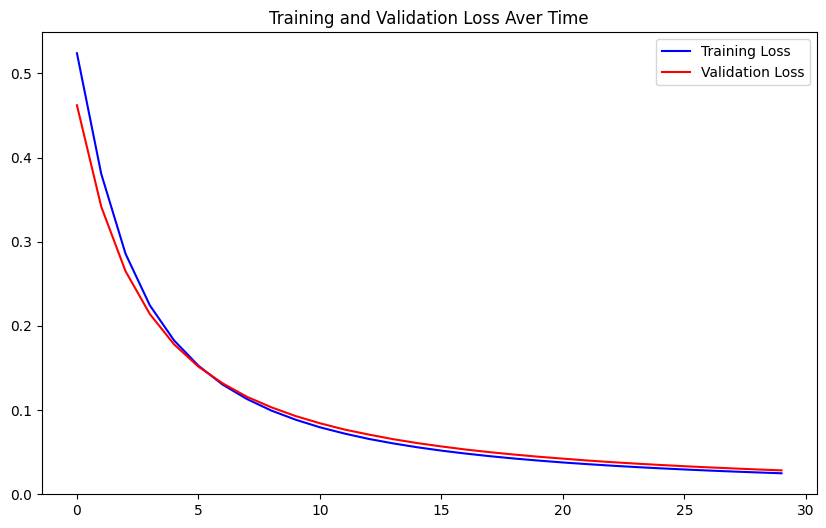

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['loss']), "-b", label="Training Loss")
plt.plot(np.array(fitting.history['val_loss']), "-r", label="Validation Loss")
plt.title("Training and Validation Loss Aver Time")
plt.legend()
plt.show()

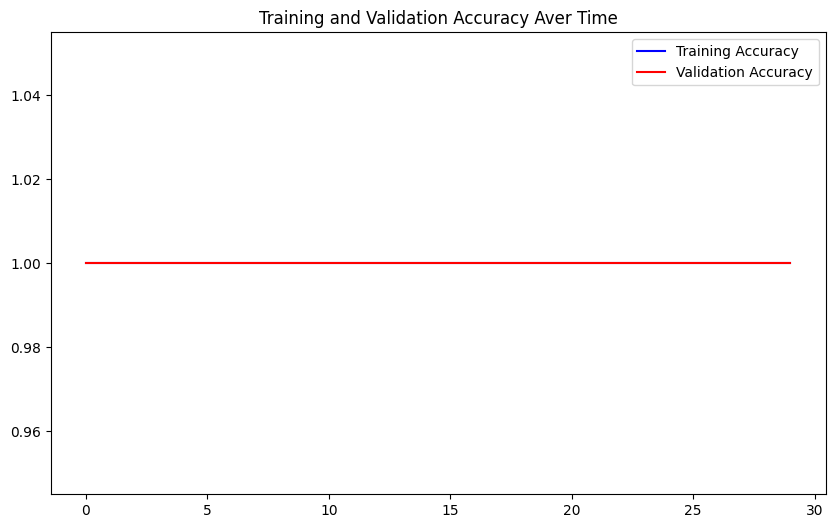

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['categorical_accuracy']), "-b", label="Training Accuracy")
plt.plot(np.array(fitting.history['val_categorical_accuracy']), "-r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Aver Time")
plt.legend()
plt.show()